# NEY-YORK TAXI TIPS - Régression linéaire

In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


In [2]:
_REP_PATH_ = os.getcwd()

## Contexte

D'après des données labélisées issues des taxis jaunes de New York, nous voulons prédire les montants des pourboires qui leur sont laissés. Après avoir analysé ces données de courses, nous allons, dans un premier temps, étudier les performances d'un modèle de régression linéaire pour l'ensemble du jeu de données. En effet, cette méthode simple nous donnera une première approche de ce problème de régression ainsi qu'une `baseline` à comparer avec différents modèles plus élaborés.  

## Importation des données

Dans cette partie, nous allons faire l'importation des données ainsi qu'une légère manipulation de celle-ci afin d'extraire la feature `trip_duration` grâce à un calcul sur les features `tpep_pickup_datetime` et `tpep_dropoff_datetime`.

In [3]:
# importation des données

train_df = pd.read_parquet(_REP_PATH_ + '/data/train.parquet')
test_df = pd.read_parquet(_REP_PATH_ + '/data/test.parquet')

## Analyse des données

### Valeurs manquantes 

In [4]:
train_df.columns[train_df.isnull().any()] # Les données d'entrainement n'ont aucune valeur manquante

Index([], dtype='object')

### Statistiques de base

In [5]:
train_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.759540,1.335090,3.213008,1.998210,1.186610,18.044264,1.538507,0.497315,3.430985,0.525877,0.999882,2.335125,0.140857,40.752187,-73.965628,40.754760,-73.971940
std,0.427365,0.847745,4.219928,9.594546,0.458398,15.839824,1.788004,0.036542,3.686474,2.020583,0.009412,0.620490,0.476090,0.032148,0.048564,0.031182,0.036295
min,1.000000,0.000000,0.010000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.576961,-74.174002,40.528686,-74.187679
25%,2.000000,1.000000,1.000000,1.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,2.000000,1.000000,1.690000,1.000000,1.000000,12.800000,1.000000,0.500000,2.800000,0.000000,1.000000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,2.000000,1.000000,3.100000,1.000000,1.000000,19.800000,2.500000,0.500000,4.200000,0.000000,1.000000,2.500000,0.000000,40.773633,-73.965146,40.773633,-73.961764
max,2.000000,7.000000,53.640000,99.000000,4.000000,214.800000,11.750000,0.500000,99.000000,49.260000,1.000000,2.500000,1.750000,40.899528,-73.726655,40.899528,-73.711025


### Visualisation des données

array([[<Axes: title={'center': 'VendorID'}>,
        <Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'fare_amount'}>],
       [<Axes: title={'center': 'extra'}>,
        <Axes: title={'center': 'mta_tax'}>,
        <Axes: title={'center': 'tip_amount'}>,
        <Axes: title={'center': 'tolls_amount'}>],
       [<Axes: title={'center': 'improvement_surcharge'}>,
        <Axes: title={'center': 'congestion_surcharge'}>,
        <Axes: title={'center': 'Airport_fee'}>,
        <Axes: title={'center': 'PU_location_lat'}>],
       [<Axes: title={'center': 'PU_location_lon'}>,
        <Axes: title={'center': 'DO_location_lat'}>,
        <Axes: title={'center': 'DO_location_lon'}>, <Axes: >]],
      

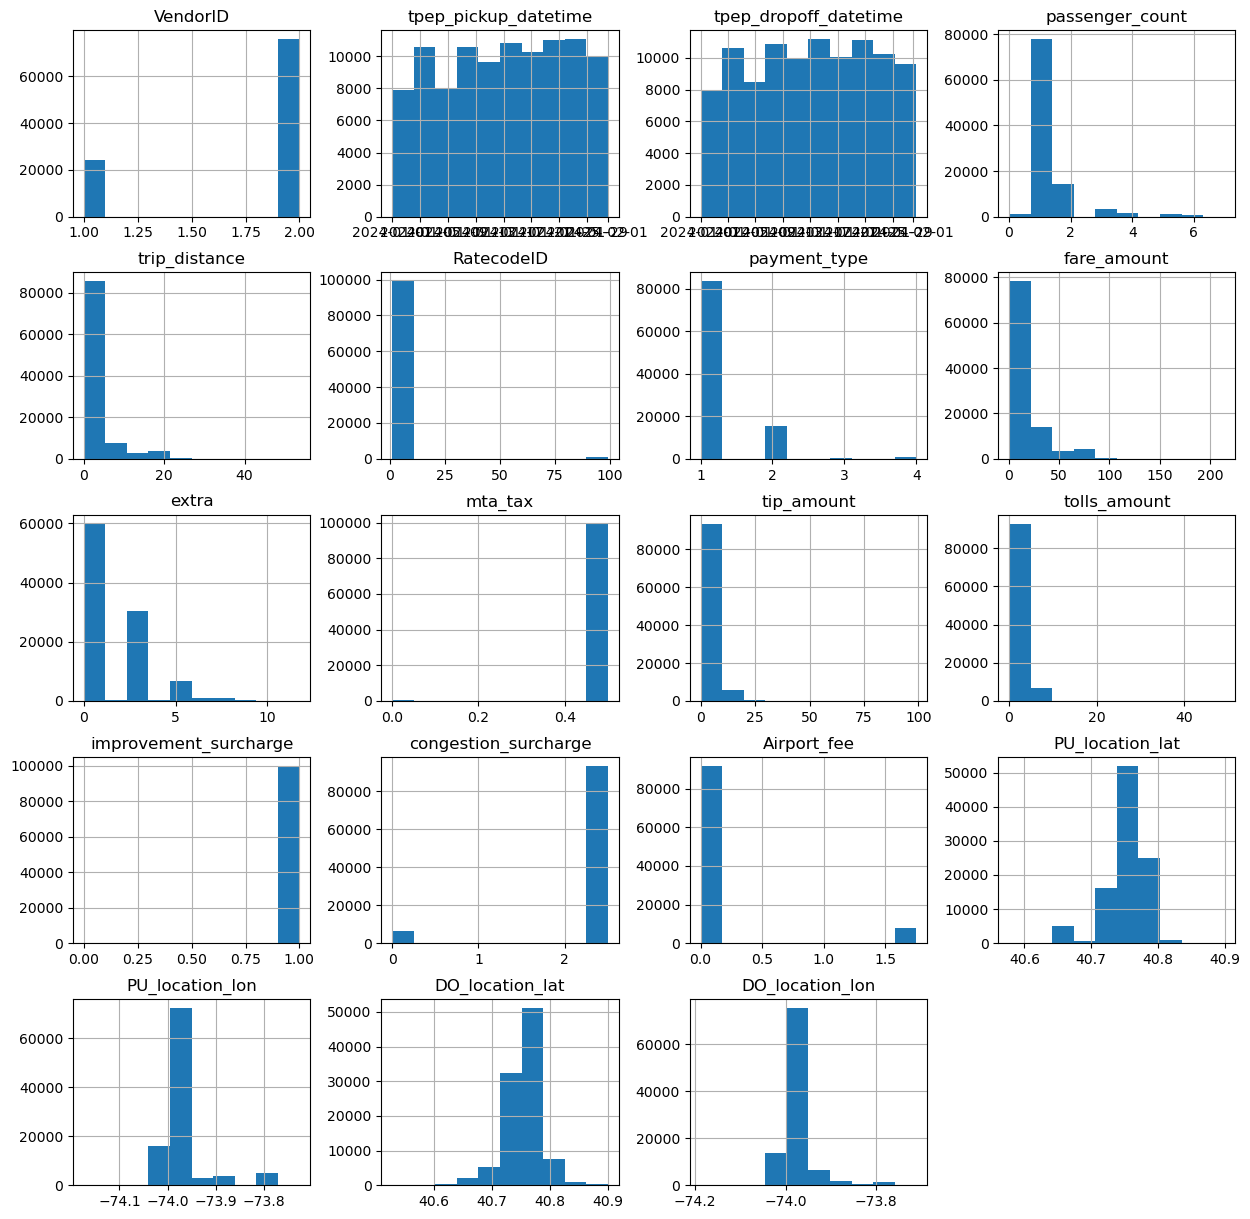

In [6]:
train_df.hist(figsize=(15,15))

Les histogrammes montrent que certaines variables présentent des valeurs aberrantes et déraisonnables. Nous devons nettoyer ces outliers.

## Nettoyage des données

In [7]:
def compute_frequency(column):
    tab = column.groupby(column).agg('count')
    return tab

def compute_statistics(column):
    stats = {}
    if column.dtype == 'float64':
        stats['mean'] = column.mean()
        stats['stddev'] = column.std()
        stats['min'] = column.min()
        stats['max'] = column.max()
        stats['q1'] = column.quantile(0.25)
        stats['q3'] = column.quantile(0.75)
    return stats

### VendorID

C'est une variable catégorielle qui indique le fournisseur des données correspondant au trajet (1: Creative Mobile Technologies, 2: VeriFone Inc.).

In [8]:
compute_frequency(train_df["VendorID"])

VendorID
1    24046
2    75954
Name: VendorID, dtype: int64

VeriFone nous a fournit environ trois fois plus de données que Creative Mobile Technologies. Cependant, les classes ont un même ordre de grandeur. Cette variable ne semble pas être intéressante dans la prediction du montant de pourboir car elle ne reflette aucune information sur les courses.

### tpep_dropoff_datetime et tpep_pickup_datetime

Des variables temporelles qui décrivent les temps de début et de fin de courses.

In [9]:
train_df.groupby(train_df["tpep_pickup_datetime"].map(lambda x : x.year)).count() # Il y a un outlier pour l'année 2023

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,
2023,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2024,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999


In [10]:
train_df = train_df[train_df["tpep_pickup_datetime"].dt.year == 2024] # On garde seulement les courses en 2024

De plus nous pouvons, d'après ces deux variables, calculer le temps de trajet de chaque courses

In [11]:
# Ajout d'une nouvelle colonne pour spécifier la durée d'un trajet (en minutes)
train_df['trip_duration'] = (train_df['tpep_dropoff_datetime'] - train_df['tpep_pickup_datetime']).dt.total_seconds()
test_df['trip_duration'] = (test_df["tpep_dropoff_datetime"] - test_df["tpep_pickup_datetime"]).dt.total_seconds() 

### Passenger Count

Cette variable représente le nombre de passager par course. Étant une valeur directement renseigné par le conducteur, elle est succeptible de présenter des erreurs.

In [12]:
compute_frequency(train_df["passenger_count"])

passenger_count
0.0     1107
1.0    77794
2.0    14103
3.0     3277
4.0     1756
5.0     1121
6.0      840
7.0        1
Name: passenger_count, dtype: int64

In [13]:
# On calcul le ratio de la classe 0 passager
((1107)/len(train_df))*100

1.107011070110701

La plupart des valeurs de `passenger_count` sont réalistes. Cependant, certains trajets affichent 0 passager. Nous allons supprimer les observations avec 0 passager, car elles représentent seulement 1.10% des données et peuvent poser des problèmes potentiels lors de la modélisation du montant des pourboires.

In [14]:
train_df = train_df[train_df["passenger_count"]>0.0]

In [15]:
compute_frequency(train_df["passenger_count"])

passenger_count
1.0    77794
2.0    14103
3.0     3277
4.0     1756
5.0     1121
6.0      840
7.0        1
Name: passenger_count, dtype: int64

Nous pouvons voir que les valeurs pour le nombre de passagers sont plus cohérentes. La plupart des trajets comptent 1 ou 2 passagers. Les trajets avec plus de six passagers sont plus rares.

<Axes: xlabel='passenger_count', ylabel='tip_amount'>

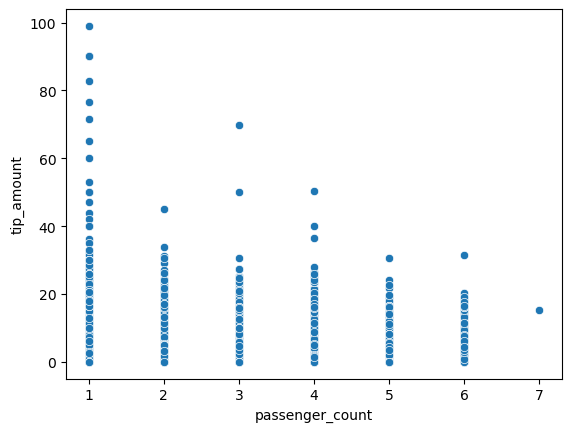

In [16]:
# Plot scatterplot
sns.scatterplot(x = train_df['passenger_count'],  y= train_df['tip_amount'])

Il n'y a pas de relation évidente entre le nombre de passagers et les pourboires. Cependant, il semble que plus le nombre de passagers est faible, plus les pourboires sont occasionnels.

### trip_distance

Cette variable représente la distance des trajets en miles.

In [17]:
# Compute statistics
trip_stats = compute_statistics(train_df['trip_distance'])
trip_stats

{'mean': 3.2192381587994983,
 'stddev': 4.226057464254769,
 'min': 0.01,
 'max': 53.64,
 'q1': 1.0,
 'q3': 3.1}

La distance de 0.01 miles n'est pas réaliste tandis que le trajet maximum est de 53 miles qui est plus réaliste. 

Afin de regarder plus en détail, nous représentons les trmps de trajets lorsque la distance est petite afin de repérer des valeurs éronnées.

<Axes: >

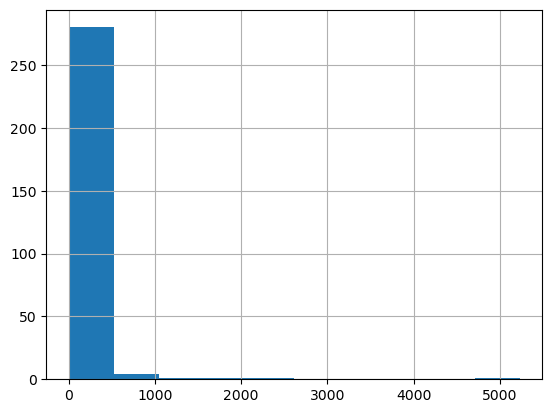

In [18]:
train_df["trip_duration"][train_df["trip_distance"] <=0.1].hist()

Nous observons qu'il y a quelques valeurs abérantes mais nous décidons de les laisser car elles ne sont pas assez marqué ! En effet, notre experience de Paris nous dis qu'il est possible de faire environ 150 en 1h20 ...

In [19]:
compute_statistics(train_df["trip_distance"])

{'mean': 3.2192381587994983,
 'stddev': 4.226057464254769,
 'min': 0.01,
 'max': 53.64,
 'q1': 1.0,
 'q3': 3.1}

La distance moyenne est de 3,2 miles. De plus, la pluspart des trajets sont entre 1 et 3.1  miles. Cest valeurs seront intéressante pour la modélisation des pourboires.

### RateCodeID

Le type de tarif (1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride)

In [20]:
compute_frequency(train_df["RatecodeID"])

RatecodeID
1.0     93999
2.0      3411
3.0       262
4.0        18
5.0       234
99.0      968
Name: RatecodeID, dtype: int64

In [21]:
# proportion de la classe 99

(968/len(train_df))*100

0.9788456093516159

On peut voir que la classe 6 n'apparait pas tandis qu'une classe 99 apparait. Cette classe représente 0,97% des données globales, nous allons la supprimer.

In [22]:
train_df = train_df[train_df["RatecodeID"] != 99]

### Store_and_fwd_flag

variable binaire indiquant si les informations ont été stocké en mémoire dans le véhicule avant d'être transmises dans le cas où le véhicule n'était pas connecté au réseau (Y=yes, N=no)

In [23]:
compute_frequency(train_df["store_and_fwd_flag"])

store_and_fwd_flag
N    97527
Y      397
Name: store_and_fwd_flag, dtype: int64

La plupart des trajets n'ont pas été enregistrés dans la mémoire du véhicule. Nous allons supprimer les valeurs nulles liées à cette variable.

### Payment_type

type de paiement (1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip)

In [24]:
compute_frequency(train_df["payment_type"])

payment_type
1    81557
2    15184
3      340
4      843
Name: payment_type, dtype: int64

Il n'y a pas de types de paiement inconnus (classe 5) ni annulés (classe 6). Nous allons conserver tous les enregistrements pour cette variable.

### fare_amount

tarif de la course sur la base de la distance et du temps

<Axes: >

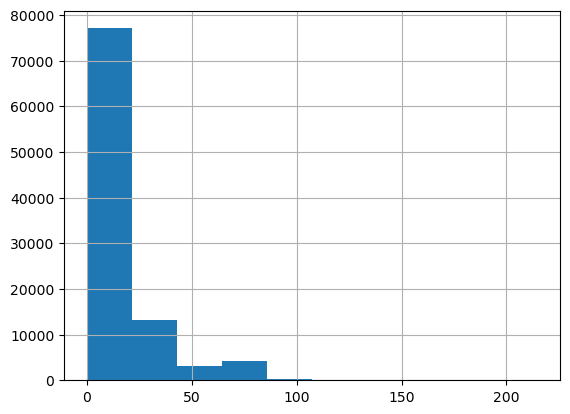

In [25]:
train_df["fare_amount"].hist()

# À CONTINUER

........

## Ajout de nouvelles features

In [26]:
## Création d'une variable pour les heures de pickup et dropout
train_df['pu_hour'] = train_df['tpep_pickup_datetime'].dt.hour + 1
train_df['do_hour'] = train_df['tpep_dropoff_datetime'].dt.hour + 1

test_df['pu_hour'] = test_df['tpep_pickup_datetime'].dt.hour + 1
test_df['do_hour'] = test_df['tpep_dropoff_datetime'].dt.hour + 1

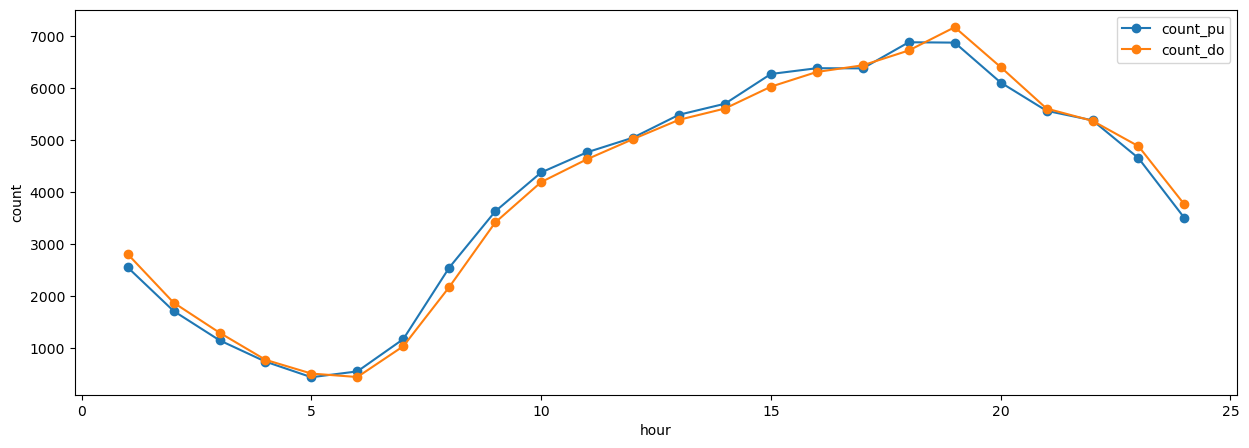

In [27]:
pu_time = pd.DataFrame({'count_pu' : train_df.groupby(['pu_hour']).size()}).reset_index()
do_time = pd.DataFrame({'count_do' : train_df.groupby(['do_hour']).size()}).reset_index()

time = pu_time.join(do_time)

# Affichage de la tandance journalière
ax = time.plot(x='pu_hour', y=['count_pu', 'count_do'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
ax.set_xlabel("hour")
plt.show()

Nous pouvons constater que, lors d'une journée typique, les heures de pointe se situent généralement entre 19 h et 21 h : les heures où la plupart des travailleurs terminent leur poste. En revanche, les heures creuses se produisent principalement tôt le matin, de 5 h à 6 h, lorsque la journée de travail commence.

In [28]:
# affichage des meilleurs meilleurs heures de prise en charge
train_df['tip_amount'].groupby(train_df['pu_hour']).agg('mean').sort_values(ascending = False).head(3)

pu_hour
6     4.682775
5     3.774921
17    3.715824
Name: tip_amount, dtype: float64

In [29]:
train_df['tip_amount'].groupby(train_df['do_hour']).agg('mean').sort_values(ascending = False).head(3)

do_hour
6     3.962170
1     3.835043
24    3.763023
Name: tip_amount, dtype: float64

Les pourboires sont plus significatifs pendant les heures de pointe ! Surtout ceux du matin. Nous allons créer une nouvelle variable pour encoder ce comportement : la variable peak_hour. Elle pourrait être utile lors de la modélisation du montant des pourboires.

In [30]:
# Create variable for peak hours
train_df['peak_hour'] = (train_df['pu_hour'].isin([6,5,17]))
test_df['peak_hour'] = (test_df['pu_hour'].isin([6,5,17]))

In [31]:
compute_frequency(train_df['peak_hour'])

peak_hour
False    90545
True      7379
Name: peak_hour, dtype: int64

Ce comportement se retrouve-t-il également selon les jours de la semaine ? Explorons davantage.

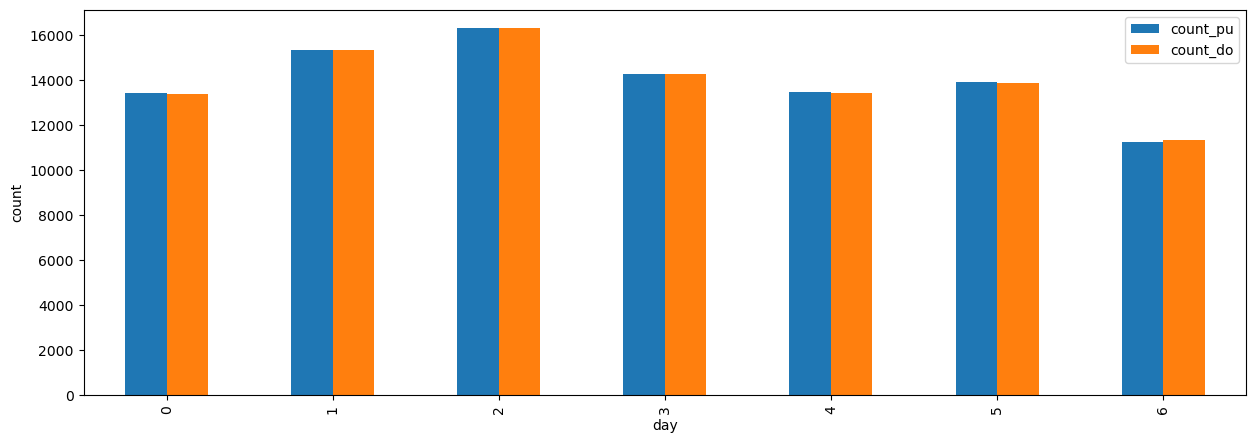

In [32]:
# create temporal variables
# add one hour so it will start at 1h00
train_df['pu_day'] = train_df['tpep_pickup_datetime'].dt.weekday
train_df['do_day'] = train_df['tpep_dropoff_datetime'].dt.weekday

test_df['pu_day'] = test_df['tpep_pickup_datetime'].dt.weekday
test_df['do_day'] = test_df['tpep_dropoff_datetime'].dt.weekday

# Create frequencies
pu_day = pd.DataFrame({'count_pu' : train_df.groupby(['pu_day']).size()}).reset_index()
do_day = pd.DataFrame({'count_do' : train_df.groupby(['do_day']).size()}).reset_index()

# Join in just one dataframe
day = pu_day.join(do_day)

# Plot trend per day
ax = day.plot(x='pu_day', y=['count_pu', 'count_do'], kind='bar', figsize=(15,5))
ax.set_ylabel("count")
ax.set_xlabel("day")
plt.show()

Ainsi, la distribution des prises en charge et des déposes est assez similaire tout au long de la journée de la semaine. Cependant, davantage de trajets ont lieu le mercredi et le jeudi par rapport aux autres jours. Il y a peut-être une relation directe avec le montant des pourboires.

In [33]:
train_df['tip_amount'].groupby(train_df['pu_day']).agg('mean')

pu_day
0    3.650139
1    3.555804
2    3.526290
3    3.519738
4    3.393346
5    3.172647
6    3.472239
Name: tip_amount, dtype: float64

Non, les pourboires sont répartis de manière égale tout au long de la semaine. Les jours ne semblent pas influencer les pourboires.
Cependant, les pourboires sont plus élevés le jeudi ! Il pourrait être pertinent de conserver la variable pu_day.
Nous l'utiliserons pour prédire le montant des pourboires.

Nous avons constaté que l'heure et le jour de la prise en charge et de la dépose influencent le montant des pourboires. Intuitivement, nous savons que les facteurs temporels ne sont pas les seuls à pouvoir affecter cette valeur.
Un passager pourrait avoir pris un taxi à 5 h du matin, mais seulement pour 5 minutes, donc le pourboire ne serait pas généreux. À l'inverse, un autre utilisateur de taxi pourrait avoir effectué un trajet longue distance en heures creuses. Le pourboire serait significatif, étant donné le temps et la distance parcourus pour le transporter d'un endroit à un autre.
En tenant compte de cela, nous allons créer de nouvelles variables pour expliquer les montants des pourboires en fonction des caractéristiques temporelles.

Pour définir si un trajet est long ou court, nous pouvons utiliser deux variables : la durée du trajet ou sa distance. Cependant, comme nous avons déjà inclus deux variables qui tiennent compte du temps (les trajets en heures de pointe seront plus longs en raison des embouteillages, de la forte demande, etc.), nous utiliserons la distance pour définir la longueur du trajet.

Text(0, 0.5, 'count')

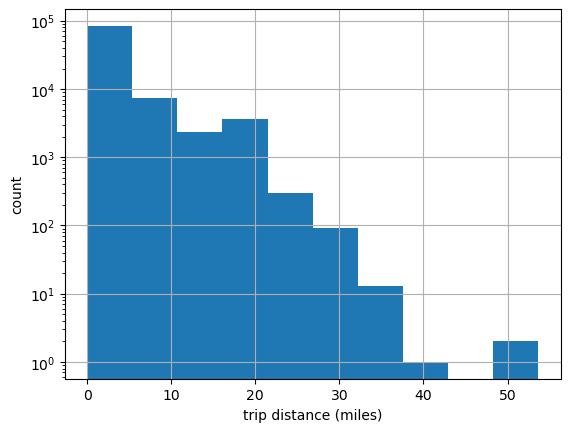

In [34]:
## Define long and short trips
ax = train_df['trip_distance'].hist()
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")

D'après l'histogramme des distances des trajets et le fait qu'il faut environ 40 miles pour traverser l'ensemble de New York, nous avons décidé d'utiliser 40 comme valeur de seuil pour catégoriser les trajets en trajets courts et longs.

In [35]:
# Define new variable (trip length)
bins = [-1, 40, np.inf]
names = [0,1]
train_df['trip_car'] = pd.cut(train_df['trip_distance'], bins, labels=names)

test_df['trip_car'] = pd.cut(test_df['trip_distance'], bins, labels=names)

In [36]:
# Compute frequency
compute_frequency(train_df['trip_car'])

trip_car
0    97922
1        2
Name: trip_car, dtype: int64

La plupart des trajets sont des trajets courts. Voyons s'il existe une corrélation avec le montant des pourboires.

In [37]:
# Compute average tips per trip length
train_df['tip_amount'].groupby(train_df['trip_car']).agg('mean')

trip_car
0     3.471771
1    25.700000
Name: tip_amount, dtype: float64

Les trajets plus longs se traduisent par des pourboires plus importants ! La variable `tip_car` peut nous aider à modéliser le montant des pourboires.

## Régression Linéaire

Dans notre exploration et synthèse des données, nous avons déjà constaté que la plupart des variables sont directement corrélées avec le montant du pourboire. De même, nous avons analysé l'influence de l'espace et du temps sur le montant du pourboire et découvert que cette variable est fortement affectée par ces facteurs. Cependant, en ce qui concerne l’espace, nous rencontrons le problème de changement de support, où il n’est pas possible d’agréger les points pour prédire le montant des pourboires par zones de New York. La prédiction du montant des pourboires doit être effectuée pour chaque trajet et non par zone. Nous avons déjà dérivé certaines variables comme la durée d'un trajet. 

Puisque l'utilisation d'un modèle spatio-temporel ne semble pas réaliste, et compte tenu de la quantité de données que nous voulons utiliser pour l'entraînement de notre modèle, nous commencerons par un modèle puissant mais simple : une régression linéaire (OLS).

Dans les problèmes de régression, la réponse la plus simple est souvent la bonne. Comme nos données présentent de fortes relations linéaires, une régression OLS pourrait effectivement bien les expliquer. Si une régression OLS ne suffit pas à prédire le montant des pourboires, elle nous permettra au moins d’identifier la signification et l’importance des variables. Cela sera utile pour appliquer d'autres modèles.

#### 

In [ ]:
og_train_df = pd.read_parquet

In [38]:
new_train_df = train_df[['passenger_count','trip_distance','trip_duration','trip_car',
                   'fare_amount','extra','mta_tax','tip_amount', 'tolls_amount',
                   'pu_hour','do_hour','peak_hour','pu_day','do_day']]

new_test_df = test_df[['passenger_count','trip_distance','trip_duration','trip_car',
                   'fare_amount','extra','mta_tax', 'tolls_amount',
                   'pu_hour','do_hour','peak_hour','pu_day','do_day']]


In [39]:
# Define categorical variables
categorical_variables = ['trip_car','pu_hour','do_hour','peak_hour','pu_day','do_day']

In [40]:
# on redéfinie les variables catégorielles
for field in categorical_variables:
    new_train_df[field] = new_train_df[field].astype('category',copy=False)
    new_test_df[field] = new_test_df[field].astype('category',copy=False)

/var/folders/3r/959b_c8j293_cdt5_svxcqch0000gn/T/ipykernel_31435/3654075562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_df[field] = new_train_df[field].astype('category',copy=False)
/var/folders/3r/959b_c8j293_cdt5_svxcqch0000gn/T/ipykernel_31435/3654075562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_df[field] = new_test_df[field].astype('category',copy=False)
/var/folders/3r/959b_c8j293_cdt5_svxcqch0000gn/T/ipykernel_31435/3654075562.py:3: SettingWithCopyWarning: 
A value

In [41]:
# divise le jeu de données
y = new_train_df['tip_amount']
x = new_train_df[['passenger_count','trip_distance','trip_duration','trip_car',
                   'fare_amount','extra','mta_tax', 'tolls_amount',
                   'pu_hour','do_hour','peak_hour','pu_day','do_day']]

In [42]:
# One hot encoding
x = pd.get_dummies(data = x)

x.dtypes

passenger_count    float64
trip_distance      float64
trip_duration      float64
fare_amount        float64
extra              float64
                    ...   
do_day_2             uint8
do_day_3             uint8
do_day_4             uint8
do_day_5             uint8
do_day_6             uint8
Length: 73, dtype: object

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2 , random_state=123)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(78339, 73)
(19585, 73)
(78339,)
(19585,)


In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [46]:
# Check coeffcients parameters
coeff_parameter = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
passenger_count,-0.063503
trip_distance,0.024390
trip_duration,-0.000013
fare_amount,0.122394
extra,0.148928
...,...
do_day_2,0.107550
do_day_3,0.002463
do_day_4,0.153399
do_day_5,0.296798


In [49]:
y_pred = model.predict(X_test)

In [60]:
max(*y_pred, *y_test)

90.0

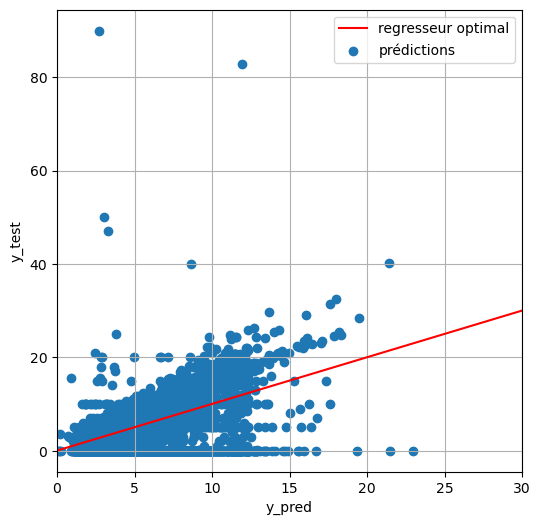

In [67]:
plt.figure(figsize=(6,6))
x = np.linspace(0,max(*y_pred, *y_test))
plt.plot(x,x, color = "red", label = "regresseur optimal")
plt.scatter(y_pred, y_test, label = "prédictions")
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,30)
plt.legend()
plt.grid(True)
plt.show()

In [55]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² : {r2}")

R² : 0.4295529149337012


Les résultats obtenue ne sont pas concluant sur l'échantillon de test. 

In [57]:
X_test_Sm= sm.add_constant(X_test)
ls=sm.OLS(y_test,X_test_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     228.8
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:13:43   Log-Likelihood:                -47918.
No. Observations:               19585   AIC:                         9.597e+04
Df Residuals:                   19519   BIC:                         9.649e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
passenger_count    -0.0620      0.024     

Avec une statistique de 228,8 et une probabilité associée de 0,00, le modèle est globalement significatif, ce qui signifie qu’au moins un des prédicteurs contribue de manière significative à l'explication de `tip_amount`.

- `fare_amount` : Avec un coefficient de 0,1227 (p < 0,001), cette variable est positivement et fortement associée au montant des pourboires. Cela suggère que plus le montant de la course est élevé, plus le pourboire est important.

- `extra` et `mta_tax` : Ces variables sont également significatives (p < 0,001) et influencent positivement le montant des pourboires, ce qui peut indiquer que les courses impliquant des frais supplémentaires ou des taxes mènent souvent à des pourboires plus élevés.

- `tolls_amount` : Avec un coefficient de 0,2754, cette variable est aussi positivement associée aux pourboires. Des trajets incluant des péages entraînent souvent un pourboire plus élevé.

Les coefficients associés aux heures de prise en charge (`pu_hour_*`) et aux heures de dépose (`do_hour_*`) révèlent que certaines heures sont statistiquement significatives et influencent les pourboires. Par exemple :
- `pu_hour_10`, `pu_hour_9` et `do_hour_24` : ces variables sont positivement associées à des pourboires plus élevés.
- À l’inverse, des heures tardives (ex. `pu_hour_23`, `pu_hour_24`) sont négativement associées aux pourboires.